In [1]:
# 🧠 PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# 🖼️ Computer Vision
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms.functional import to_pil_image

# 📊 Utilities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 📦 1. Dataset Setup (same as you provided)
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir  = "/kaggle/input/brain-tumor-mri-dataset/Testing"

from torchvision.models import ResNet18_Weights
weights = ResNet18_Weights.DEFAULT

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()  # Automatically uses correct mean/std for ImageNet
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir, transform=transform)

train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)
class_names  = train_data.classes

In [4]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [5]:
model = BrainTumorCNN().to(device)

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze base layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

def train_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                val_correct += (out.argmax(1) == y).sum().item()
        val_acc = val_correct / len(val_loader.dataset)

        print(f"📊 Epoch {epoch+1:02d}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

In [7]:
train_model(model, train_loader, val_loader, epochs=20)


📊 Epoch 01: Train Acc = 0.7379, Val Acc = 0.8706
📊 Epoch 02: Train Acc = 0.8473, Val Acc = 0.8986
📊 Epoch 03: Train Acc = 0.8687, Val Acc = 0.8986
📊 Epoch 04: Train Acc = 0.8798, Val Acc = 0.8969
📊 Epoch 05: Train Acc = 0.8784, Val Acc = 0.9073
📊 Epoch 06: Train Acc = 0.8936, Val Acc = 0.9143
📊 Epoch 07: Train Acc = 0.8959, Val Acc = 0.9126
📊 Epoch 08: Train Acc = 0.9000, Val Acc = 0.9196
📊 Epoch 09: Train Acc = 0.9014, Val Acc = 0.9021
📊 Epoch 10: Train Acc = 0.9002, Val Acc = 0.9126
📊 Epoch 11: Train Acc = 0.9070, Val Acc = 0.9318
📊 Epoch 12: Train Acc = 0.9074, Val Acc = 0.9178
📊 Epoch 13: Train Acc = 0.9109, Val Acc = 0.9231
📊 Epoch 14: Train Acc = 0.9072, Val Acc = 0.9213
📊 Epoch 15: Train Acc = 0.9111, Val Acc = 0.9266
📊 Epoch 16: Train Acc = 0.9175, Val Acc = 0.9301
📊 Epoch 17: Train Acc = 0.9210, Val Acc = 0.9231
📊 Epoch 18: Train Acc = 0.9181, Val Acc = 0.9266
📊 Epoch 19: Train Acc = 0.9204, Val Acc = 0.9353
📊 Epoch 20: Train Acc = 0.9214, Val Acc = 0.9283


In [8]:
# Save model
torch.save(model.state_dict(), "resnet18_brain_tumor.pth")

print("✅ Model saved!")

# Load model later
# model.load_state_dict(torch.load("/kaggle/working/brain_resnet18.pth"))
# model.eval()


✅ Model saved!


In [9]:
model.eval()
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.8940


In [10]:
def grad_cam(model, input_tensor, target_class):
    model.eval()

    # Store gradients and activations
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks on layer4
    hook_f = model.layer4.register_forward_hook(forward_hook)
    hook_b = model.layer4.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor.unsqueeze(0))
    model.zero_grad()

    class_score = output[0, target_class]
    class_score.backward()

    # Detach hooks
    hook_f.remove()
    hook_b.remove()

    # Get saved tensors
    grads = gradients[0].squeeze()
    acts = activations[0].squeeze()

    # Weighted average
    weights = grads.mean(dim=[1, 2])
    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    # Normalize heatmap
    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else cam

    return cam

In [11]:
def grad_cam(model, input_tensor, target_class):
    model.eval()

    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Register hooks on the LAST CONV block (ResNet18: layer4)
    hook_f = model.layer4.register_forward_hook(forward_hook)
    hook_b = model.layer4.register_full_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor.unsqueeze(0))
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Clean up hooks
    hook_f.remove()
    hook_b.remove()

    # Sanity check
    if not gradients or not activations:
        raise RuntimeError("⚠️ Gradients or activations were not captured. Check hooks.")

    # Convert to CAM
    grads = gradients[0].squeeze(0)        # shape: (C, H, W)
    acts = activations[0].squeeze(0)       # shape: (C, H, W)
    weights = grads.mean(dim=[1, 2])       # shape: (C,)

    cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(device)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max() if cam.max() != 0 else cam

    return cam


In [12]:
model.eval()
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        correct += (preds.argmax(1) == y).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"📊 Test Accuracy: {test_acc:.4f}")

📊 Test Accuracy: 0.8940


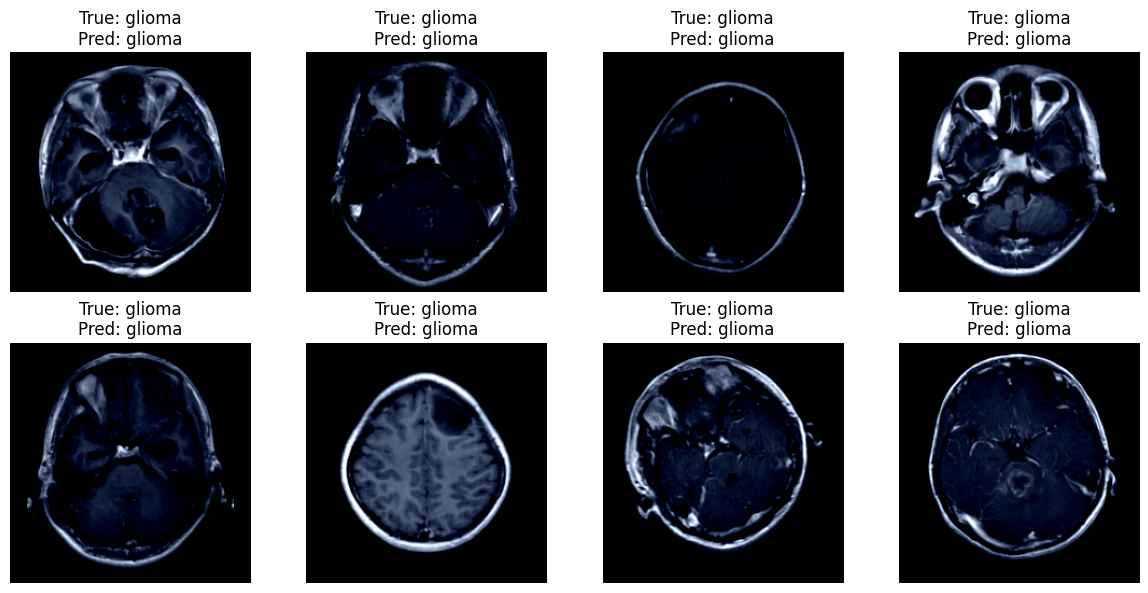

In [13]:
class_names = train_data.classes

x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
with torch.no_grad():
    preds = model(x).argmax(1)

plt.figure(figsize=(12, 6))
for i in range(8):
    img = x[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y[i]]}\nPred: {class_names[preds[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [14]:
# Invert label mapping
idx_to_class = {v: k for k, v in test_data.class_to_idx.items()}

model.eval()
image_names = []
predicted_labels = []

with torch.no_grad():
    for i, (inputs, _) in enumerate(tqdm(test_loader)):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Get corresponding file paths
        batch_paths = test_data.samples[i * test_loader.batch_size : i * test_loader.batch_size + len(inputs)]
        for j, (img_path, _) in enumerate(batch_paths):
            image_name = os.path.basename(img_path)
            label_name = idx_to_class[preds[j]]
            image_names.append(image_name)
            predicted_labels.append(label_name)

# Save as CSV
submission_df = pd.DataFrame({
    "image_name": image_names,
    "label": predicted_labels
})
submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv created!")

100%|██████████| 41/41 [00:07<00:00,  5.40it/s]


✅ submission.csv created!
